# Function to Compare CLimate Model and Observational Data
**Description:** Funtion that takes in datasets from climate models and observations and compares them to determine suitability for different applications.  
**Input Data:** Climate Model and Observational Data (1 dataset each)  
**Output Data:** Summary Statistics, T-test statistcs, F-test statistics, map of differences, graphs of pdfs  
**Author:** Emma Perkins  
**Date:** June 2022

In [1]:
# import relevant packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy.stats as stats
from astropy.io import ascii
from astropy.table import Table

### Load Data
**These data should already be reformated into a single file each with a single (same) variable of interest and same timestep size using the Script4DataExtraction or Script4Data_Extraction_Compare**

In [2]:
# climate model data:
clim_path = '/glade/campaign/cgd/ppc/eperkins/data/cmip/'  # change to your path
clim_file = 'CMIP6_B1850_piControl.001_TP_1900_2000_1D_WArctic.nc'   # change to your file
clim_data = xr.open_dataarray(clim_path+clim_file)

# observational data:
obs_path = '/glade/campaign/cgd/ppc/eperkins/data/era5/'  # change to your path
obs_file = 'era5_tp_1975_2022_1D_WArctic.nc'   # change to your file
obs_data = xr.open_dataarray(obs_path+obs_file)

# masking file
mask_file = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc')  # change to your masking file
mask = mask_file.mask

### Function to Match Times
**Description:** Matches temporal extent and resolution of two datasets.  
**Input Data:** Observational data and climate model data with the same temporal resolution (hourly, daily, monthly, etc.) that have already been compressed down to one file using the Script4DataExtraction notebook or python script.  
**Output Data:** Observational data and climate model data with matching time dimensions (same start and end dates as well as same length).  
**Process:**  
1) Matches the start times of the data by determining which dataset has the earlier first date and selecting only the data from that dataset beginning on the first date of the dataset with the later first date.  
2) Matches the end times of the data by determining which dataset has the later last date and selecting only the data from that dataset from the beginning until the last date of the dataset with the earlier last date. *At this point both datasets should have the same start and end date but may still be different lengths if one of them includes leap days while the other does not.*  
3) Address leapday differences checking if the length of the time dimension for both datasets is the same. If it is, the two datasets have been successfully time corrected and are renamed to reflect this new status. Otherwise, the length of the time dimension of the two datasets is not the same so the days that do not appear in the shorter of the two datasets are removed from the longer of the two datasets, presumably these are leap days. After this has been done the datasets are then successfully time-corrected and are renamed to reflect this new status.  
4) The time-corrected datasets are returned by the time-matching function.  

In [3]:
def time_match(obs_data, clim_data):
    # convert to same time index
    clim_data['time'] = clim_data.indexes['time'].to_datetimeindex()

    # 1) match start times-----------------------------------------------------
    if np.where(obs_data.time == clim_data.time[0])[0].size > 0:
        obs_start = np.where(obs_data.time == clim_data.time[0])[0][0]
        obs_data = obs_data.isel(time=np.arange(obs_start, len(obs_data.time), 1))
    elif np.where(clim_data.time == obs_data.time[0])[0].size > 0:
        clim_start = np.where(clim_data.time == obs_data.time[0])[0][0]
        clim_data = clim_data.isel(time=np.arange(clim_start, len(clim_data.time), 1))

    # 2) match end times-------------------------------------------------------
    if np.where(obs_data.time == clim_data.time[-1])[0].size > 0:
        obs_end = np.where(obs_data.time == clim_data.time[-1])[0][0]
        obs_data = obs_data.isel(time=np.arange(0, obs_end + 1, 1))
    elif np.where(clim_data.time == obs_data.time[-1])[0].size > 0:
        clim_end = np.where(clim_data.time == obs_data.time[-1])[0][0]
        clim_data = clim_data.isel(time=np.arange(0, clim_end + 1, 1))

    # 3) adress leap year differences------------------------------------------
    if len(clim_data.time) == len(obs_data.time):
        clim_data_tc = clim_data
        obs_data_tc = obs_data
    else:
        if len(obs_data.time) > len(clim_data.time):
            obs_data_noleap = np.zeros([len(clim_data.time), len(obs_data.lat), len(obs_data.lon)])
            for i in range(0, len(clim_data.time)):
                obs_data_noleap[i, :, :] = obs_data.sel(time=clim_data.time[i])
            # convert back to xarray DataArray
            lat_coord = obs_data.lat.to_numpy()
            lon_coord = obs_data.lon.to_numpy()
            time_coord = clim_data.time.to_numpy()
            obs_data_tc = xr.DataArray(obs_data_noleap, coords={'time': time_coord, 'lat': lat_coord, 
                                'lon': lon_coord}, dims=['time', 'lat', 'lon'], name='obs_data') 
            # obs_data_tc = time-corrected observational data

            clim_data_tc = clim_data

        elif len(clim_data.time) > len(obs_data.time):
            clim_data_noleap = np.zeros([len(obs_data.time), len(clim_data.lat), len(clim_data.lon)])
            for i in range(0, len(obs_data.time)):
                clim_data_noleap[i, :, :] = clim_data.sel(time=obs_data.time[i]).to_array()
            # convert back to xarray DataArray
            lat_coord = clim_data.lat.to_numpy()
            lon_coord = clim_data.lon.to_numpy()
            time_coord = obs_data.time.to_numpy()
            clim_data_tc = xr.DataArray(clim_data_noleap, coords={'time': time_coord, 'lat': lat_coord, 
                                    'lon': lon_coord}, dims=['time', 'lat', 'lon'], name='clim_data')
            # clim_data_tc = time-corrected climate data

            obs_data_tc = obs_data

    time_index = clim_data_tc.time  # create universal time index to be used in space_match for creating DataArrays

    # 4) return time-corrected data--------------------------------------------
    return(obs_data_tc, clim_data_tc, time_index)

### Function to Match Lat, Lon Coords
**Description:** Matches spatial extent and resolution of two datasets that already have the same temporal extent and resolution.  
**Input Data:** Observational data and climate model data that has already been time-corrected after being passed through the time-match function.  
**Output Data:** Observational data and climate data that have the same time extent, spatial extent, and resolution, and are ready for analysis.  
**Process:**  
1) Sort data by ascending latitude in preparation for matching latitudes.
2) Matches starting latitude by:
    * Determining which latitude in each dataset is closest to the lowest latitude in the other dataset, call this the starting latitude.
    * If the starting latitude of a given dataset is not the same as the lowest latitude in its own dataset, select only the data from the starting latitude upward in that dataset.   
3) Matches ending latitude by:
    * Determining which latitude in each dataset is closest to the highest latitude in the other dataset, call this the ending latitude.
    * If the ending latitude of a given dataset is not the same as the last latitude in that dataset, select only the data from the first latitude in that dataset (as adjusted by step 1) until the ending latitude.  
4) Matches starting longitude by:
    * Determining which longitude in each dataset is closest to the lowest lowest longitude in the other dataset, call this the starting longitude.
    * If the starting longitude of a given dataset is not the same as the lowest longitude in its own dataset, select only the data from the starting longitude upward in that dataset.  
5) Matches ending longitude by:
    * Determining which longitude in each dataset is closest to the highest longitude in the other dataset, call this the ending longitude.
    * If the ending longitude of a given dataset is not the same as the last longitude in that dataset, select only the data from the first longitude in that dataset (as adjusted by step 5) until the ending longitude.   
6) Addresses differences in spatial resolution by:
    * Checking if the length of the latitude variable is the same for each dataset.
    * If not, determine which dataset has lower resolution and select only the data from the higher resolution dataset that are at the grid points of the points for the lower resolution dataset. In places where there is not an exact grid point match, choose the nearest grid point.   

In [4]:
def space_match(obs_data_tc, clim_data_tc, time_index):  # get all input vars from output of time_match()
    # 1) sort by ascending lats------------------------------------------------
    obs_data_tc = obs_data_tc.sortby('lat', ascending=True)
    clim_data_tc = clim_data_tc.sortby('lat', ascending=True)

    # 2) match start lats------------------------------------------------------
    obs_lat_start = obs_data_tc.sel(lat=clim_data_tc.lat[0], method='nearest').lat
    clim_lat_start = clim_data_tc.sel(lat=obs_data_tc.lat[0], method='nearest').lat

    if np.where(obs_data_tc.lat == obs_lat_start)[0][0] > 0:
        obs_lat_start_i = np.where(obs_data_tc.lat == obs_lat_start)[0][0]
        obs_data_tc = obs_data_tc.isel(lat=np.arange(obs_lat_start_i, len(obs_data_tc.lat), 1))
    elif np.where(clim_data_tc.lat == clim_lat_start)[0][0] > 0:
        clim_lat_start_i = np.where(clim_data_tc.lat == clim_lat_start)[0][0]
        clim_data_tc = clim_data_tc.isel(lat=np.arange(clim_lat_start_i, len(clim_data_tc.lat), 1))

    # 3) match end lats--------------------------------------------------------
    obs_lat_end = obs_data_tc.sel(lat=clim_data_tc.lat[-1], method='nearest').lat
    clim_lat_end = clim_data_tc.sel(lat=obs_data_tc.lat[-1], method='nearest').lat

    if obs_data_tc.lat[np.where(obs_data_tc.lat == obs_lat_end)[0][0]] != obs_data_tc.lat[-1]:
        obs_lat_end_i = np.where(obs_data_tc.lat == obs_lat_end)[0][0]
        obs_data_tc = obs_data_tc.isel(lat=np.arange(0, obs_lat_end_i, 1))
    elif clim_data_tc.lat[np.where(clim_data_tc.lat == clim_lat_end)[0][0]] != clim_data_tc.lat[-1]:
        clim_lat_end_i = np.where(clim_data_tc.lat == clim_lat_end)[0][0]
        clim_data_tc = clim_data_tc.isel(lat=np.arange(0, clim_lat_end_i, 1))

    # 4) match start lons------------------------------------------------------
    obs_lon_start = obs_data_tc.sel(lon=clim_data_tc.lon[0], method='nearest').lon
    clim_lon_start = clim_data_tc.sel(lon=obs_data_tc.lon[0], method='nearest').lon

    if np.where(obs_data_tc.lon == obs_lon_start)[0][0] > 0:
        obs_lon_start_i = np.where(obs_data_tc.lon == obs_lon_start)[0][0]
        obs_data_tc = obs_data_tc.isel(lon=np.arange(obs_lon_start_i, len(obs_data_tc.lon), 1))
    elif np.where(clim_data_tc.lon == clim_lon_start)[0][0] > 0:
        clim_lon_start_i = np.where(clim_data_tc.lon == clim_lon_start)[0][0]
        clim_data_tc = clim_data_tc.isel(lon=np.arange(clim_lon_start_i, len(clim_data_tc.lon), 1))

    # 5) match end lats--------------------------------------------------------
    obs_lon_end = obs_data_tc.sel(lon=clim_data_tc.lon[-1], method='nearest').lon
    clim_lon_end = clim_data_tc.sel(lon=obs_data_tc.lon[-1], method='nearest').lon

    if obs_data_tc.lon[np.where(obs_data_tc.lon == obs_lon_end)[0][0]] != obs_data_tc.lon[-1]:
        obs_lon_end_i = np.where(obs_data_tc.lon == obs_lon_end)[0][0]
        obs_data_tc = obs_data_tc.isel(lon=np.arange(0, obs_lon_end_i, 1))
    elif clim_data_tc.lon[np.where(clim_data_tc.lon == clim_lon_end)[0][0]] != clim_data_tc.lon[-1]:
        clim_lon_end_i = np.where(clim_data_tc.lon == clim_lon_end)[0][0]
        clim_data_tc = clim_data_tc.isel(lon=np.arange(0, clim_lon_end_i, 1))

    # 6) address differences in spatial resolution -- currently just downselecting to resolution of lowest resolution data
    if len(obs_data_tc.lat) != len(clim_data_tc.lat):
        if len(obs_data_tc.lat) > len(clim_data_tc.lat):
            obs_data_matchres = np.zeros([len(obs_data_tc.time), len(clim_data_tc.lat), len(clim_data_tc.lon)])
            for i in range(0, len(clim_data_tc.lat)):
                for j in range(0, len(clim_data_tc.lon)):
                    obs_data_matchres[:, i, j] = obs_data_tc.sel(lat=clim_data_tc.lat[i], lon=clim_data_tc.lon[j], method = 'nearest')

            # currently a numpy array, need to convert back to xarray DataArray
            lat_coord = clim_data_tc.lat.to_numpy()
            lon_coord = clim_data_tc.lon.to_numpy()
            time_coord = time_index
            obs_data_analysis = xr.DataArray(obs_data_matchres, coords={'time': time_coord, 'lat': lat_coord, 
                                'lon': lon_coord}, dims=['time', 'lat', 'lon'], name='obs_data')
            clim_data_analysis = clim_data_tc

        elif len(clim_data_tc.lat) > len(obs_data_tc.lat):
            clim_data_matchres = np.zeros([len(clim_data_tc.time), len(obs_data_tc.lat), len(obs_data_tc.lon)])
            for i in range(0, len(obs_data_tc.lat)):
                for j in range(0, len(obs_data_tc.lon)):
                    clim_data_matchres[:, i, j] = clim_data_tc.sel(lat=obs_data_tc.lat[i], lon=obs_data_tc.lon[j], method='nearest')

            # currently a numpy array, need to convert back to xarray DataArray
            lat_coord = obs_data_tc.lat.to_numpy()
            lon_coord = obs_data_tc.lon.to_numpy()
            time_coord = time_index
            clim_data_analysis = xr.DataArray(clim_data_matchres, coords={'time': time_coord, 'lat': lat_coord, 
                                'lon': lon_coord}, dims=['time', 'lat', 'lon'], name='clim_data')
            obs_data_analysis = obs_data_tc

    else:
        # remane data for bookkeeping purposes
        clim_data_analysis = clim_data_tc
        obs_data_analysis = obs_data_tc
    return(obs_data_analysis, clim_data_analysis)

### Function to Mask Out Ocean/Land
**Description:** Creates 4 new data files corresponding to the observational data with the ocean masked out (obs_land), the observational data with the land masked out (obs_ocean), the climate model data with the ocean masked out (clim_land), and the climate model data with the land masked out (clim_ocean).  
**Input Data:** Observational and climate model data that has already been corrected for differences in temporal and spatial extent and resolution using the time_match() and space_match() functions respectively.
**Output Data:**  
1) obs_land -- observational data with the ocean masked out (only contains land points, everything else is NaN)  
2) obs_ocean -- observational data with the land masked out (only contains ocean points, everything else is NaN)  
3) clim_land -- climate model data with the ocean masked out (only contains land points, everything else is NaN)  
4) clim_ocean -- climate model data with the land masked out (only contains ocean points, everything else is NaN)  
**Process:**  
1) Converts mask longitude coordinates to long1 to match observational and climate data for analysis.  
2) Matches mask coordinates to data coordinates by:  
    * creating empty mask array with same lat, lon dimensions as observational data (which should also be the same as for the climate model data by virtue of using the space_match() function).  
    * for each lat, lon point in the observational data (which should be the same as the lat, lon points in the climate model data), find the indices of the nearest latitude and longitude in the mask data and select the mask data point corresponding to those lat, lon indices.  
3) Convert new matched mask back to xarray DataArray  
4) Create separate masks for the ocean and the land by:  
    * finding the coordinates where the coordinate-matched mask is zero (this corresponds to the ocean) and where it is one (this corresponds to the land).  
    * creating new mask files for both masking out the ocean (ocean_mask) and masking out the land (land_mask) with the same dimensions as the coordinate-matched mask.  
    * for the ocean mask, in every place where the coordinate-matched mask is 0, replace the corresponding point in the ocean mask with a NaN, in every place where the coordinate-matched mask is 1, replace the corresponding point in the ocean mask with 1.  
    * for the land mask, in every place where the coordinate-matched mask is 0, replace the corresponding point in the ocean mask with 1, in every place where the coordinate-matched mask is 1, replace the corresponding point in the land mask with a NaN.  
5) Create masked datasets for the observational and climate model data by:  
    * For both the climate model data and the observational data, create 2 new arrays of zeros with the same dimensions as the original data (in total should have 4 new arrays of zeros).  
    * for each time in the observational and climate model data, multiply the observational data by each mask separately (land_mask and ocean_mask), and store in the new arrays.  
6) Return the masked datasets.

In [5]:
def mask_fun(obs_data_analysis, clim_data_analysis, mask):
    mask = mask.rename({'xc': 'lon', 'yc': 'lat'})

    # 1) convert mask lon to long1---------------------------------------------
    new_lon = (mask.lon.sel(nj=0) + 180) % 360 - 180
    for j in range(0, len(mask.nj)):
        mask.lon[j, :] = new_lon

    # 2) match mask coordinates to data coordinates----------------------------
    mask_new = np.zeros([len(obs_data_analysis.lat), len(obs_data_analysis.lon)])
    for i in range(0, len(obs_data_analysis.lat)):
        for j in range(0, len(obs_data_analysis.lon)):
            lat_dif = mask.lat[:, 0] - obs_data_analysis.lat[i]
            lat_index = np.where(np.abs(lat_dif) == np.amin(np.abs((mask.lat[:, 0]) - obs_data_analysis.lat[i])))[0][0]
            lon_dif = mask.lon[0, :] - obs_data_analysis.lon[j]
            lon_index = np.where(np.abs(lon_dif) == np.amin(np.abs((mask.lon[0, :]) - obs_data_analysis.lon[j])))[0][0]
            mask_new[i, j] = mask.sel(ni=lon_index).sel(nj=lat_index)

    # 3) convert back to xarray DataArray--------------------------------------
    lat_coord = obs_data_analysis.lat.to_numpy()
    lon_coord = obs_data_analysis.lon.to_numpy()
    mask_new = xr.DataArray(mask_new, coords={'lat': lat_coord,
                                'lon': lon_coord}, dims=['lat','lon'],
                                 name='mask')

    # 4) create separate ocean mask and land mask------------------------------
    zero_lats = np.where(mask_new == 0)[0]
    zero_lons = np.where(mask_new == 0)[1]
    one_lats = np.where(mask_new != 0)[0]
    one_lons = np.where(mask_new != 0)[1]

    ocean_mask = np.zeros([len(obs_data_analysis.lat), len(obs_data_analysis.lon)])
    land_mask = np.zeros([len(obs_data_analysis.lat), len(obs_data_analysis.lon)])

    # create mask where oceans are NaN and Land is 1
    for i in range(0, len(zero_lats)):
        ocean_mask[zero_lats[i], zero_lons[i]] = np.NaN
    for j in range(0, len(one_lats)):
        ocean_mask[one_lats[j], one_lons[j]] = 1

    # create mask where land is NaN and Ocean in 1
    for i in range(0, len(zero_lats)):
        land_mask[zero_lats[i], zero_lons[i]] = 1
    for j in range(0, len(one_lats)):
        land_mask[one_lats[j], one_lons[j]] = np.NaN

    # 5) create masked files for observational and climate data----------------
    obs_land = np.zeros([len(obs_data_analysis.time), len(obs_data_analysis.lat), len(obs_data_analysis.lon)])
    obs_ocean = np.zeros([len(obs_data_analysis.time), len(obs_data_analysis.lat), len(obs_data_analysis.lon)])

    for i in range(0, len(obs_data_analysis.time)):
        obs_land[i, :, :] = obs_data_analysis[i, :, :]*ocean_mask

    for i in range(0, len(obs_data_analysis.time)):
        obs_ocean[i, :, :] = obs_data_analysis[i, :, :]*land_mask

    clim_land = np.zeros([len(clim_data_analysis.time), len(clim_data_analysis.lat), len(clim_data_analysis.lon)])
    clim_ocean = np.zeros([len(clim_data_analysis.time), len(clim_data_analysis.lat), len(clim_data_analysis.lon)])

    for i in range(0, len(clim_data_analysis.time)):
        clim_land[i, :, :] = clim_data_analysis[i, :, :]*ocean_mask

    for i in range(0, len(clim_data_analysis.time)):
        clim_ocean[i, :, :] = clim_data_analysis[i, :, :]*land_mask
    
    time_coord = obs_data_analysis.time
    obs_land = xr.DataArray(obs_land, coords={'time': time_coord, 'lat': lat_coord,
                                'lon': lon_coord}, dims=['time', 'lat','lon'],
                                 name='obs_land')
    obs_ocean = xr.DataArray(obs_ocean, coords={'time': time_coord, 'lat': lat_coord,
                                'lon': lon_coord}, dims=['time', 'lat','lon'],
                                 name='obs_land')
    clim_land = xr.DataArray(clim_land, coords={'time': time_coord, 'lat': lat_coord,
                                'lon': lon_coord}, dims=['time', 'lat','lon'],
                                 name='obs_land')
    clim_ocean = xr.DataArray(clim_ocean, coords={'time': time_coord, 'lat': lat_coord,
                                'lon': lon_coord}, dims=['time', 'lat','lon'],
                                 name='obs_land')

    # Return the masked datasets-----------------------------------------------
    return(obs_land, obs_ocean, clim_land, clim_ocean)

### Function to Compare Model with Observations
**Input Data:**  Observational data and climate model data that has already been corrected for differences in temporal and spatial extent and resolution using the time_match() and space_match() functions respectively.  
**Outputs:**  
* "AvgDifMap" -- Map plot of difference between the climate model and the observational data for the variable of interest averaged over the full temporal extent of the data. 
* "TwoHist" -- Plot of histograms of data values for both the model and observational data.  
* "DifHist" -- Histogram of the values of the difference between the climate model and observational data.  
* Summary Statistics -- mean, standard deviation, min, and max for each dataset as well as the difference between the two datasets, mean squared error, root mean squared error.  
* T-test -- test-statistic and p-value for one-sample t-test to determine if mean of difference is statistically different than 0.  
* F-test -- test statistic and p-value for F-test to determine if variances of observational data and climate data are statistically different from each other for full data, spatial variance only, and temporal variance only.

**Process:**  
1) Finds difference between model data and observations.  
2) Plots difference averaged over all time by:
    * Checks if longitude coordinates are continuous.  
    * If coordinates are continuous, plot as usual.
    * Otherwise, coordinates are discontinuous (i.e. crosses 180 lon without covering the whole globe), use a plot with 180 as the central longitude instead of 0.   
3) Plots histogram of each distribution (climate model data and observational data).  
4) Plots histogram of the differences between climate model data and observational data with a vertical line at zero.  
5) Plots timeseries of spatial mean of each distribution (climate model and observational data).  
6) Plots timeseries of spatial mean of difference between climate model and observational data with a horizontal line at zero.  
7) Calculates summary statistics (mean , standard deviation, minimum, and maximum) for each of the observational data, climate model data, and their differences.  
8) Performs a T-test to determine if the mean of the differences is statistically different than 0, indicating that the two populations (climate model data and observational data) have statistically different means.  
9) Performs three F-tests to determine if the internal variability of each of the climate model and observational datasets are statistically different for:  
    * the datasets as a whole  
    * spatial variability only  
    * temporal variability only  
10) Calculates the mean squared error and root mean squared error.

In [6]:
def plot_compare(obs_data_analysis, clim_data_analysis):
    # 1) difference between model and observations
    dif = clim_data_analysis - obs_data_analysis

    # 2) plot difference averaged over all time in data------------------------
    dif_avg = dif.mean(dim='time')
    
    lon_step = dif_avg.lon[2] - dif_avg.lon[1]
    lon_min = min(dif_avg.lon)
    lon_max = max(dif_avg.lon)
    lev1 = np.arange(-1, 1.01, 0.01)  # change to your levels
    cmap1 = plt.cm.RdBu_r
    map_name = 'AvgDifMap'  # change to your map name for saving
    if (lon_max - lon_min + lon_step)/lon_step == len(dif_avg.lon):  # check if␣longitudes are continuous, if there is no gap plot across as usual (central longitude = 0)
        plt.figure(figsize=(15, 5))
        ax1 = plt.axes(projection=ccrs.PlateCarree())
        dif_avg.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), cmap=cmap1, levels=lev1, extend='both')
        ax1.coastlines()
        plt.title('Average Difference Between Model and Observations')
        plt.savefig(map_name)
        plt.show()
    else:  # if longitudes are not continuous, plot with 180 as central longitude instead
        new_lon = np.zeros(len(dif_avg.lon))
        for i in range(0, len(dif_avg.lon)):
            if dif_avg.lon[i] < 0:
                new_lon[i] = dif_avg.lon[i] % 180
            else:
                new_lon[i] = dif_avg.lon[i] - 180
        dif_avg['lon'] = new_lon
        cm = 180
        proj = ccrs.PlateCarree(central_longitude=cm)
        fig = plt.figure(figsize = [9,5])
        ax1 = fig.add_subplot(1, 1, 1, projection=proj)
        dif_avg.plot.contourf(ax=ax1, cmap=cmap1, levels=lev1, extend='both')
        ax1.coastlines()
        ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        plt.title('Average Difference Between Model and Observations')
        plt.savefig(map_name)
        plt.show()
    
    # 3) plot histogram of each------------------------------------------------
    plt.figure(figsize=(9, 5))
    clim_data_analysis.plot.hist(bins=10000, color='r', alpha=0.5, label='Model Data')
    obs_data_analysis.plot.hist(bins=10000, color='k', alpha=0.5, label='Observational Data')
    plt.legend()
    plt.ylabel('Count')
    plt.title('Distribution of Model Predictions vs Observations')
    plt.xlim([-0.001, 0.1])   #----- add x-axis limits if desired
    #plt.ylim([0, 2*10**6])
    plt.savefig('TwoHist.png')
    plt.show()

    # 4) plot histogram of differences-----------------------------------------
    plt.figure(figsize=(9, 5))
    dif.plot.hist(bins=10000, color='b', alpha = 0.5, label = 'Data')
    plt.axvline(x = 0, color = 'r', alpha = 0.5, label = 'Zero')
    plt.legend()
    plt.ylabel('Count')
    plt.title('Distribution of Differences Between Model Predictions and Observations')
    plt.xlim([-0.1, 0.1])   #----- add x-axis limits if desired
    #plt.ylim([0, 0.6*10**6])
    plt.savefig('DifHist.png')
    plt.show()
    
    # 5) plot timeseries of each
    obs_ts = obs_data_analysis.mean(dim='lat').mean(dim='lon')
    clim_ts = clim_data_analysis.mean(dim='lat').mean(dim='lon')
    plt.figure(figsize=(15, 10))
    obs_ts.plot(color='b', alpha=0.5, label='Observational Data Mean')
    clim_ts.plot(color='r', alpha=0.5, label='Climate Model Data Mean')
    plt.legend()
    plt.title('Timeseries of Mean for Climate Model and Observational Data')
    plt.savefig('TwoTS.png')
    plt.show()
    
    # 6) plot timeseries of difference
    dif_ts = (clim_data_analysis - obs_data_analysis).mean(dim='lat').mean(dim='lon')
    plt.figure(figsize=(15,10))
    dif_ts.plot(color='b', label='Data')
    plt.axhline(y=0, color='r', label='Zero')
    plt.title('Timeseries of Difference Between Climate Model and Observational Data')
    plt.savefig('DifTS.png')
    plt.show()

    # 7) print summary statistics of each dataset------------------------------
    obs_mean = float(obs_data_analysis.mean())  # save mean and stdev for use in calculating test statistics
    obs_stdev = float(obs_data_analysis.std())
    obs_min = np.amin(obs_data_analysis)
    obs_max = np.amax(obs_data_analysis)
    
    clim_mean = float(clim_data_analysis.mean())
    clim_stdev = float(clim_data_analysis.std())
    clim_min = np.amin(clim_data_analysis)
    clim_max = np.amax(clim_data_analysis)
    
    dif_mean = float(dif.mean())
    dif_stdev = float(dif.std())
    dif_min = np.amin(dif)
    dif_max = np.amax(dif)
    
    # 8) T-test to determine if difference is different than 0-----------------
    n = len(dif.lat) * len(dif.lon) * len(dif.time)
    T_stat = (dif_mean - 0)/(dif_stdev/np.sqrt(n))
    T_p_val = stats.t.sf(abs(T_stat), n-1)

    # 9) F-test to detemine if variances are statistically different from each other
    obs_var_full = float(obs_data_analysis.var(skipna=True))
    clim_var_full = float(clim_data_analysis.var(skipna=True))
    obs_var_space = float((obs_data_analysis.mean(dim='time').std())**2)
    clim_var_space = float((clim_data_analysis.mean(dim='time').std())**2)
    obs_var_time = obs_data_analysis.var(dim='time', skipna=True)
    clim_var_time = clim_data_analysis.var(dim='time', skipna=True)
    obs_var_time_avg = float(obs_var_time.mean())
    clim_var_time_avg = float(clim_var_time.mean())

    obs_n_full = float(obs_data_analysis.count())
    clim_n_full = float(clim_data_analysis.count())
    obs_n_space = float(obs_data_analysis.mean(dim='time').count())
    clim_n_space = float(clim_data_analysis.mean(dim='time').count())
    obs_n_time = float(obs_data_analysis.time.count())
    clim_n_time = float(clim_data_analysis.time.count())

    F_stat_full = obs_var_full/clim_var_full
    F_p_val_full = 1-stats.f.cdf(F_stat_full, obs_n_full-1, clim_n_full-1)
    F_stat_space = obs_var_space/clim_var_space
    F_p_val_space = 1-stats.f.cdf(F_stat_space, obs_n_space-1, clim_n_space-1)
    F_stat_time = obs_var_time_avg/clim_var_time_avg
    F_p_val_time = 1-stats.f.cdf(F_stat_time, obs_n_time-1, clim_n_time-1)

    # 10) Find mean squared error-----------------------------------------------
    mse = float(np.square(np.subtract(obs_data_analysis, clim_data_analysis)).mean())
    rmse = np.sqrt(mse)

    return(obs_mean, obs_stdev, obs_min, obs_max, obs_var_full, obs_var_space, obs_var_time_avg, 
           clim_mean, clim_stdev, clim_min, clim_max, clim_var_full, clim_var_space, clim_var_time_avg, 
           dif_mean, dif_stdev, dif_min, dif_max,
           mse, rmse, 
           F_stat_full, F_stat_space, F_stat_time, F_p_val_full, F_p_val_space, F_p_val_time,
           T_stat, T_p_val)

### Combine all of the functions
**Description:** Combines the time_match(), space_match(), mask_fun(), and plot_compare() functions to do all of the temporal and spatial extent and resolution matching as well as the masking and model comparison in one step.  
**Input Data:** Observational data and climate model data with the same temporal resolution (hourly, daily, monthly, etc.) that have already been compressed down to one file using the Script4DataExtraction notebook or python script.  
**Outputs:** Ascii file containing all of the statistical analysis for the model comparison.  
**Process:**  
1. Runs the data through each of the time_match(), space_match(), mask_fun(), and plot_compare() functions in order  
2. Compiles all of the outputs from plot_compare into a table with columns of the name of the statistic/statistical test, and the values for each for the full comparison, comparison over land only, and comparison over ocean only.  
3. Writes the statistical table to an ascii file.

In [7]:
def mod_compare(obs_data, clim_data):
    # 1) run original data through all of the analysis functions
    obs_data_tc, clim_data_tc, time_index = time_match(obs_data, clim_data)
    print('Temporal correction complete.')  # just for indication that program is progressing
    obs_data_analysis, clim_data_analysis = space_match(obs_data_tc, clim_data_tc, time_index)
    print('Spatial correction complete.')  # just for indication that program is progressing
    obs_land, obs_ocean, clim_land, clim_ocean = mask_fun(obs_data_analysis, clim_data_analysis, mask)
    print('Ocean/Land masking complete.')  # just for indication that program is progressing
    full_obs_mean, full_obs_stdev, full_obs_min, full_obs_max, full_obs_var_full, full_obs_var_space, full_obs_var_time, full_clim_mean, full_clim_stdev, full_clim_min, full_clim_max, full_clim_var_full, full_clim_var_space, full_clim_var_time, full_dif_mean, full_dif_stdev, full_dif_min, full_dif_max, full_mse, full_rmse, full_F_stat_full, full_F_stat_space, full_F_stat_time, full_F_p_val_full, full_F_p_val_space, full_F_p_val_time, full_T_stat, full_T_p_val = plot_compare(obs_data_analysis, clim_data_analysis)
    land_obs_mean, land_obs_stdev, land_obs_min, land_obs_max, land_obs_var_full, land_obs_var_space, full_land_var_time, full_land_mean, land_clim_stdev, land_clim_min, land_clim_max, land_clim_var_full, land_clim_var_space, land_clim_var_time, land_dif_mean, land_dif_stdev, land_dif_min, land_dif_max, land_mse, land_rmse, land_F_stat_full, land_F_stat_space, land_F_stat_time, land_F_p_val_full, land_F_p_val_space, land_F_p_val_time,  land_T_stat, land_T_p_val = plot_compare(obs_land, clim_land)
    ocean_obs_mean, ocean_obs_stdev, ocean_obs_min, ocean_obs_max, ocean_obs_var_full, ocean_obs_var_space, ocean_obs_var_time, ocean_clim_mean, ocean_clim_stdev, ocean_clim_min, ocean_clim_max, ocean_clim_var_full, ocean_clim_var_space, ocean_clim_var_time, ocean_dif_mean, ocean_dif_stdev, ocean_dif_min, ocean_dif_max, ocean_mse, ocean_rmse, ocean_F_stat_full, ocean_F_stat_space, ocean_F_stat_time, ocean_F_p_val_full, ocean_F_p_val_space, ocean_F_p_val_time, ocean_T_stat, ocean_T_p_val = plot_compare(obs_ocean, clim_ocean)

    # 2) create a table with all of the statistics in one place
    full_stats = Table({'statistic': ['obs_mean', 'obs_stdev', 'obs_min', 'obs_max', 'obs_var_full', 'obs_var_space', 'obs_var_time_avg', 
                                      'clim_mean', 'clim_stdev', 'clim_min', 'clim_max', 'clim_var_full', 'clim_var_space', 'clim_var_time_avg', 
                                      'dif_mean', 'dif_stdev', 'dif_min', 'dif_max', 'mse', 'rmse', 'F_stat_full', 'F_stat_space', 'F_stat_time', 'F_p_val_full', 'F_p_val_space', 'F_p_val_time', 'T_stat', 'T_p_val'],
                    'Full stats': [full_obs_mean, full_obs_stdev, full_obs_min, full_obs_max, full_obs_var_full, full_obs_var_space, full_obs_var_time, full_clim_mean, full_clim_stdev, full_clim_min, full_clim_max, full_clim_var_full, full_clim_var_space, full_clim_var_time, full_dif_mean, full_dif_stdev, full_dif_min, full_dif_max, full_mse, full_rmse, full_F_stat_full, full_F_stat_space, full_F_stat_time, full_F_p_val_full, full_F_p_val_space, full_F_p_val_time, full_T_stat, full_T_p_val],
                    'Land stats': [land_obs_mean, land_obs_stdev, land_obs_min, land_obs_max, land_obs_var_full, land_obs_var_space, full_land_var_time, full_land_mean, land_clim_stdev, land_clim_min, land_clim_max, land_clim_var_full, land_clim_var_space, land_clim_var_time, land_dif_mean, land_dif_stdev, land_dif_min, land_dif_max, land_mse, land_rmse, land_F_stat_full, land_F_stat_space, land_F_stat_time, land_F_p_val_full, land_F_p_val_space, land_F_p_val_time,  land_T_stat, land_T_p_val],
                    'Ocean stats': [ocean_obs_mean, ocean_obs_stdev, ocean_obs_min, ocean_obs_max, ocean_obs_var_full, ocean_obs_var_space, ocean_obs_var_time, ocean_clim_mean, ocean_clim_stdev, ocean_clim_min, ocean_clim_max, ocean_clim_var_full, ocean_clim_var_space, ocean_clim_var_time, ocean_dif_mean, ocean_dif_stdev, ocean_dif_min, ocean_dif_max, ocean_mse, ocean_rmse, ocean_F_stat_full, ocean_F_stat_space, ocean_F_stat_time, ocean_F_p_val_full, ocean_F_p_val_space, ocean_F_p_val_time, ocean_T_stat, ocean_T_p_val]},
                   names=['statistic', 'Full stats', 'Land stats', 'Ocean stats'])

    # 3) 
    ascii.write(full_stats, 'full_stats.txt', overwrite=True)
    full_stats.pprint(max_lines=-1, max_width=-1)
    return(full_stats)

/glade/work/eperkins/miniconda3/envs/analysis3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  This is separate from the ipykernel package so we can avoid doing imports until


Temporal correction complete.
Spatial correction complete.
Ocean/Land masking complete.


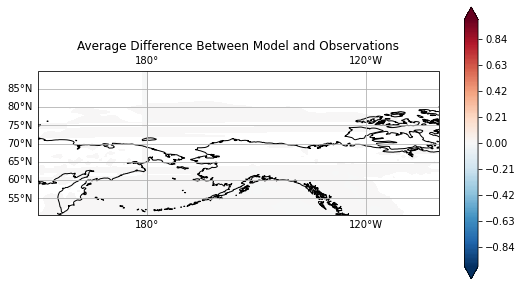

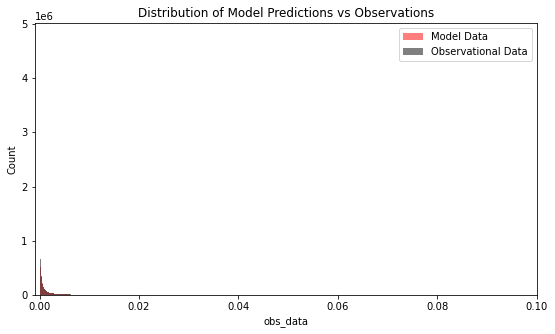

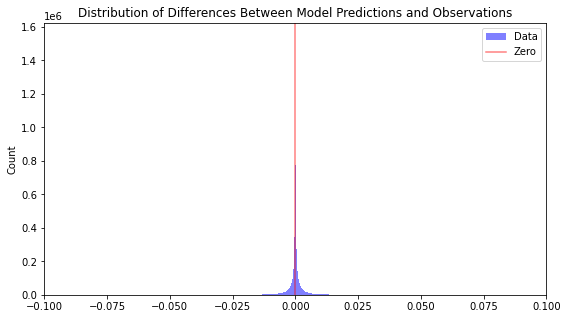

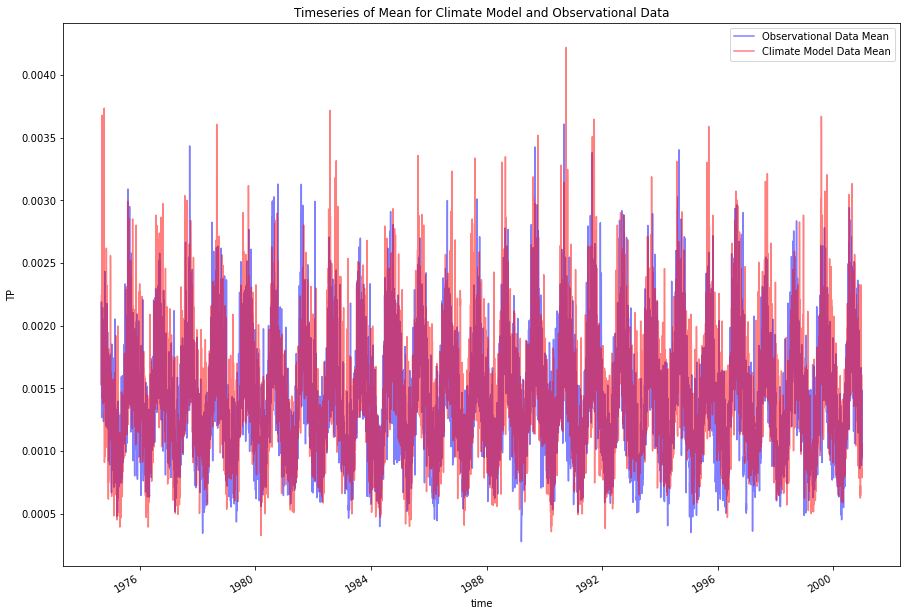

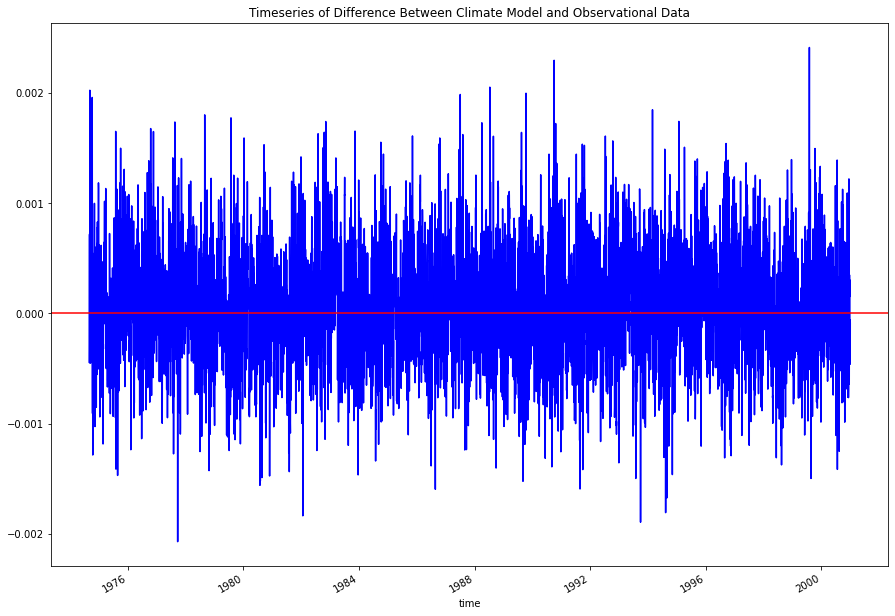

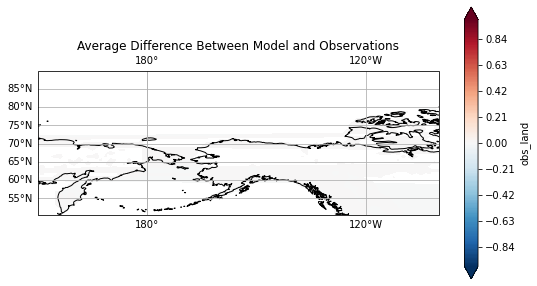

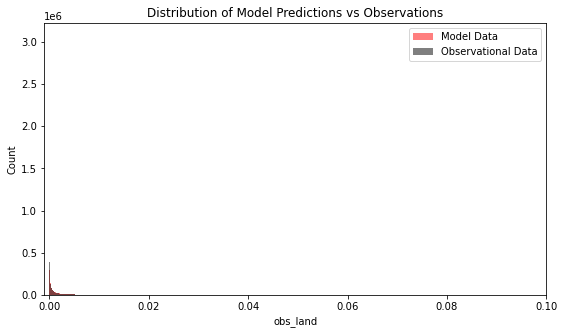

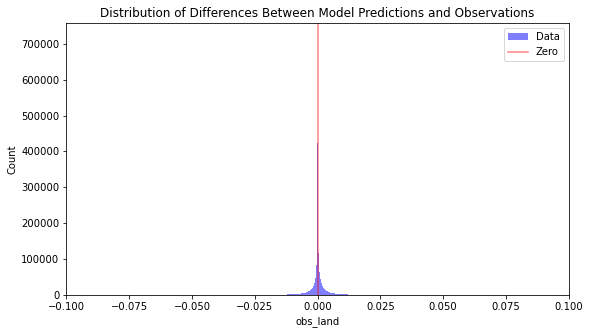

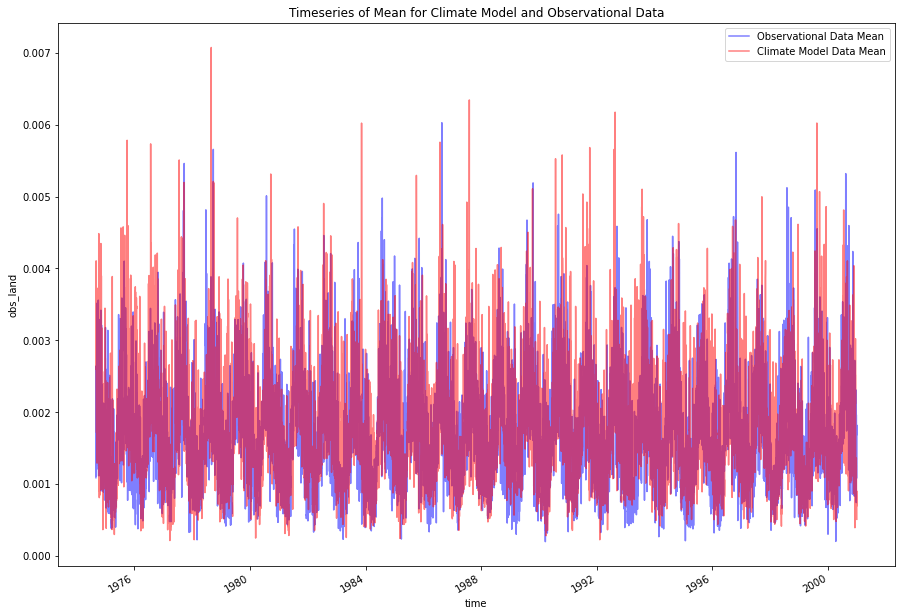

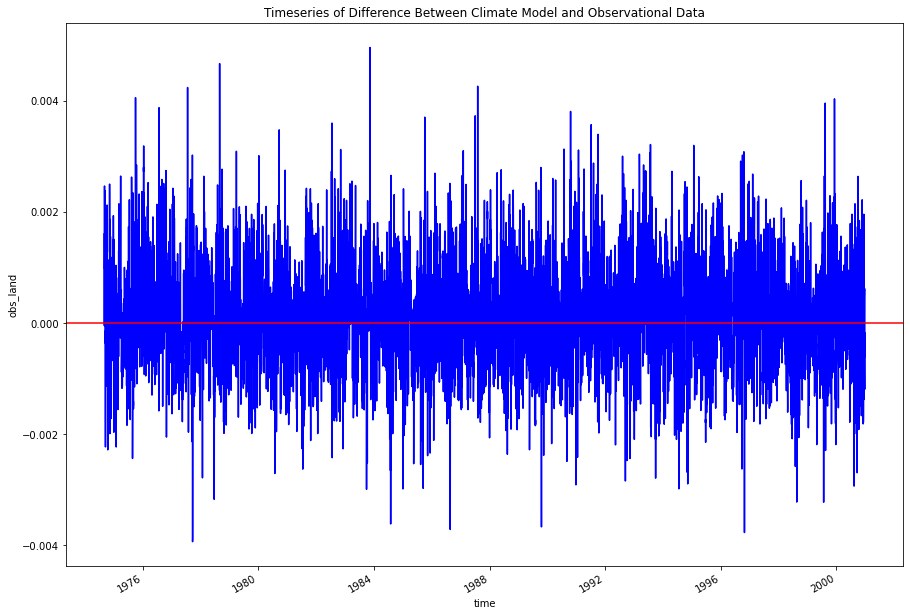

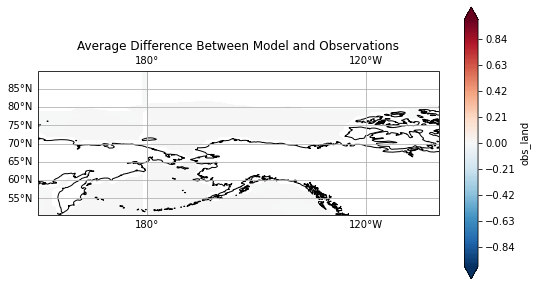

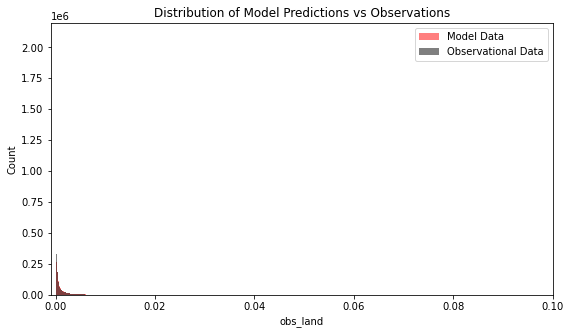

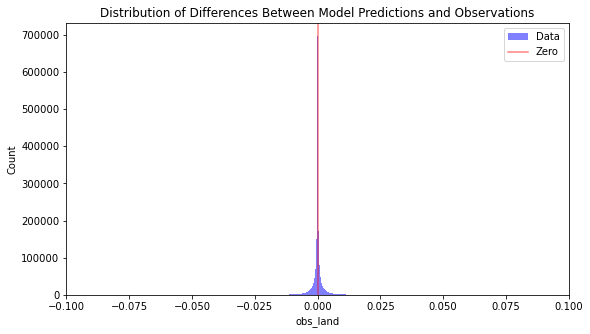

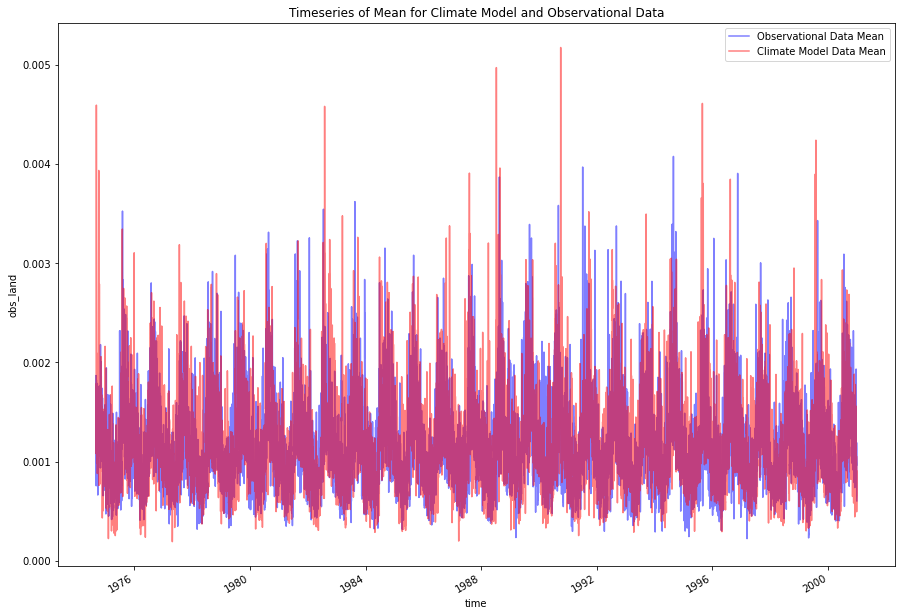

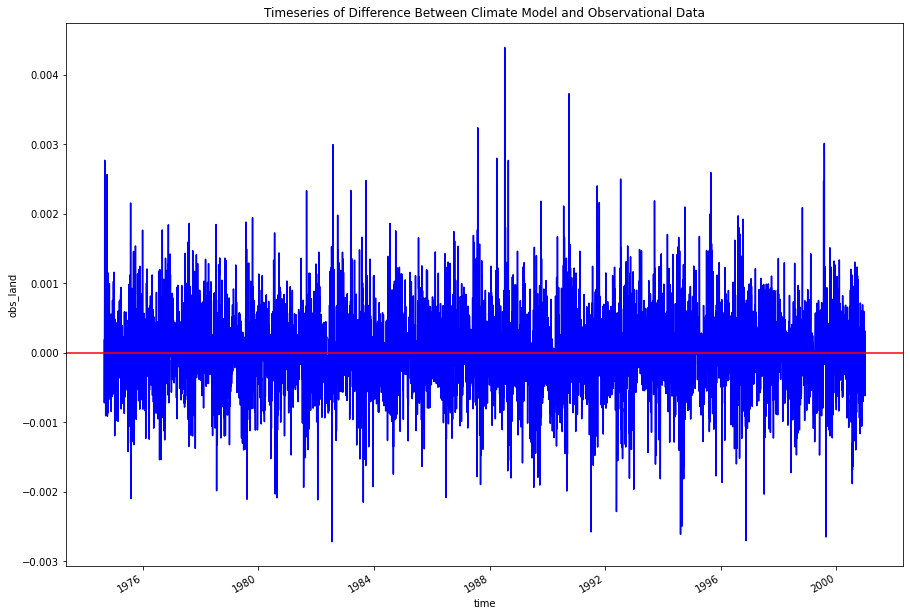

    statistic           Full stats             Land stats            Ocean stats      
----------------- ---------------------- ---------------------- ----------------------
         obs_mean  0.0013840232725502557  0.0016142589271583036  0.0012421677742085573
        obs_stdev  0.0032003967599628334   0.003933227993186383  0.0026398442664508736
          obs_min                    0.0                    0.0                    0.0
          obs_max     0.1750185489654541     0.1750185489654541    0.12313103675842285
     obs_var_full 1.0242539421180601e-05 1.5470282446384985e-05   6.96877775111355e-06
    obs_var_space 1.5058896807803044e-06 2.0222846917713185e-06 1.1349391395477702e-06
 obs_var_time_avg  8.736649740135195e-06  1.344799775420922e-05  5.833838611531313e-06
        clim_mean  0.0014411955140805608  0.0016923603078774741  0.0012864449084430151
       clim_stdev  0.0032020199713412314   0.003678699816084513  0.0028581926847057963
         clim_min                    0.0   

In [8]:
full_stats = mod_compare(obs_data, clim_data)

In [9]:
ascii.write(full_stats, '/glade/campaign/cgd/ppc/eperkins/results/TotalPrecip/stats/WArcticTotalPrecipStatsCMIPB1850_piControl.txt', overwrite=True)